# Miniproject Two:
## Authored by Hussein, Behnaz, and Arneet:


# 20 News Groups Dataset:

## Import the necesseray modules:

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import numpy as np
import pandas as pd
import re
import string
from sklearn.naive_bayes import MultinomialNB as MN
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import time


## Load the *Datasets*

In [3]:
# Load the dataset and remove headers, footer, and quotes:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))


## Prepare Dataframes then Remove Punctuation and Numbers:


In [4]:
train_df = pd.DataFrame({'data': newsgroups_train.data, 'target': newsgroups_train.target})
train_df.head()

,data,target
0,I was wondering if anyone out there could enli...,7
1,A fair number of brave souls who upgraded thei...,4
2,"well folks, my mac plus finally gave up the gh...",4
3,\nDo you have Weitek's address/phone number? ...,1
4,"From article <C5owCB.n3p@world.std.com>, by to...",14


In [5]:
test_df = pd.DataFrame({'data': newsgroups_test.data, 'target': newsgroups_test.target})
test_df.head()

,data,target
0,I am a little confused on all of the models of...,7
1,I'm not familiar at all with the format of the...,5
2,"\nIn a word, yes.\n",0
3,\nThey were attacking the Iraqis to drive them...,17
4,\nI've just spent two solid months arguing tha...,19


In [6]:
# Text preprocessing steps - remove numbers, captial letters and punctuation
alphanumeric = lambda x: re.sub(r"""\w*\d\w*""", ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
strip = lambda x: " ".join(str.rsplit(x))

train_df['data'] = train_df.data.map(alphanumeric).map(punc_lower)
train_df['data'] = train_df.data.map(strip)
train_df.head()

,data,target
0,i was wondering if anyone out there could enli...,7
1,a fair number of brave souls who upgraded thei...,4
2,well folks my mac plus finally gave up the gho...,4
3,do you have weitek s address phone number i d ...,1
4,from article world std com by tombaker world s...,14


In [7]:
# Text preprocessing steps - remove numbers, captial letters and punctuation
alphanumeric = lambda x: re.sub(r"""\w*\d\w*""", ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
strip = lambda x: " ".join(str.rsplit(x))

test_df['data'] = test_df.data.map(alphanumeric).map(punc_lower)
test_df['data'] = test_df.data.map(strip)
test_df.head()

,data,target
0,i am a little confused on all of the models of...,7
1,i m not familiar at all with the format of the...,5
2,in a word yes,0
3,they were attacking the iraqis to drive them o...,17
4,i ve just spent two solid months arguing that ...,19


## Use TFID Vectorizor:

In [8]:
#Initialize a TFID Vectorizer that removes English stop words and 
# selects words that appear more than 3 times
tfid_vect = TfidfVectorizer(stop_words='english', min_df=3)
# Create the labels 
Y_train = newsgroups_train.target
Y_test = newsgroups_test.target
# Vectorize the datasets and use a common vocab to transform the test df
X_train = tfid_vect.fit_transform(train_df.data).toarray()
vocab = tfid_vect.vocabulary_
tfid_vect2 = TfidfVectorizer(vocabulary=vocab)
X_test = tfid_vect2.fit_transform(test_df.data).toarray()
# print names
print(tfid_vect.get_feature_names())
print(tfid_vect2.get_feature_names())

['aa', 'aaa', 'aamir', 'aardvark', 'aarnet', 'aaron', 'aas', 'aau', 'ab', 'abandon', 'abandoned', 'abbey', 'abbott', 'abbreviation', 'abbreviations', 'abc', 'abd', 'abdomen', 'abdominal', 'abduction', 'abdul', 'abdullah', 'aberdeen', 'aberrant', 'abhor', 'abide', 'abiding', 'abilities', 'ability', 'able', 'abnormal', 'abnormalities', 'aboard', 'abode', 'abolish', 'abolished', 'abominable', 'abomination', 'abominations', 'abort', 'aborted', 'abortion', 'abortions', 'abound', 'abraham', 'abridged', 'abroad', 'abruptly', 'abs', 'absence', 'absent', 'absolute', 'absolutely', 'absolutes', 'absolutist', 'absorb', 'absorbed', 'absorbing', 'absorption', 'abstact', 'abstinence', 'abstract', 'abstraction', 'abstracts', 'absurd', 'absurdity', 'abu', 'abundance', 'abundant', 'abuse', 'abused', 'abuser', 'abusers', 'abuses', 'abusing', 'abusive', 'abyss', 'ac', 'acad', 'academia', 'academic', 'academically', 'academics', 'academy', 'acc', 'accel', 'accelerate', 'accelerated', 'accelerating', 'accel

# KFoldCV
Method to do cross validation

In [9]:
def cross_validation_split(n, n_folds=5):
    #get the number of data samples in each split
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds

def kfoldCV(x , y, n_folds , model):
    score_val = np.zeros(n_folds)
    for f, (tr, val) in enumerate(cross_validation_split(np.array(x).shape[0], n_folds)):
        model = model.fit(np.array(x)[tr], np.array(y)[tr])
        score_val[f] = evaluate_acc(np.array(y)[val], model.predict(np.array(x)[val]))
    return score_val, score_val.mean()

# method to get accuracy
def evaluate_acc (Predicted_label, True_label):
    return np.sum(True_label == Predicted_label)/True_label.shape[0]
       

# Naive Bayes:

Vectorized implementation of Naive Bayes as we were struggling using nested for loops.

In [11]:
class MultinomialNB(object):
    # set alpha to be 1 by default
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def fit(self, X, y):
        # count number of data points or samples
        count_sample = X.shape[0]
        # Check each class and count 
        classes = [[x for x, t in zip(X, y) if t == c] for c in np.unique(y)]
        # Calculate the prior
        self.class_log_prior_ = [np.log(len(i) / count_sample) for i in classes]
        # calculate count of each word for each class and add self.alpha as smoothing
        count = np.array([np.array(i).sum(axis=0) for i in classes]) + self.alpha
        # calculate the log probability of each word
        self.feature_log_prob_ = np.log(count / count.sum(axis=1)[np.newaxis].T)
        return self

    def predict_log_proba(self, X):
        return [(self.feature_log_prob_ * x).sum(axis=1) + self.class_log_prior_
                for x in X]

    def predict(self, X):
        # maximize probability
        return np.argmax(self.predict_log_proba(X), axis=1)



## Test for Naive Bayes:

**First Pass testing for Naive Bayes**

In [11]:
# create a classifier
clf2 = MultinomialNB(alpha=0.1)
# fit the classifier
start = time.time()
clf2.fit(X_train,Y_train)
# predict on training and get train score
train_pred = clf2.predict(X_train)
# predict on test and get test score
test_pred = clf2.predict(X_test)
end = time.time()

In [12]:
print("score on training data :", evaluate_acc(train_pred, Y_train))
print("score on test data :", evaluate_acc(test_pred, Y_test))      
print("Time for training (fitting and predicting on both train and test sets) :", end - start, "seconds")    

score on training data : 0.9309704790525013
score on test data : 0.6953000531067446
Time for training (fitting and predicting on both train and test sets) : 18.098313808441162 seconds


## Compare with SciKit Learn Naive Bayes

In [13]:
# classifier
clf = MN()
start = time.time()
clf.fit(X_train,Y_train)
Y_test_pred = clf.predict(X_test)
sklearn_score_train = clf.score(X_train,Y_train)
Y_test_pred = clf.predict(X_test)
sklearn_score_test = clf.score(X_test,Y_test)
end = time.time()
print("Sklearn's score on training data :",sklearn_score_train)
print("Sklearn's score on testing data :",sklearn_score_test)
print("Time for training for SciKit Nb(fitting and predicting on both train and test sets) :", end - start, "seconds")


Sklearn's score on training data : 0.8646809262860173
Sklearn's score on testing data : 0.6771109930961232
Time for training for SciKit Nb(fitting and predicting on both train and test sets) : 5.27067756652832 seconds


SciKit Learn's Naive Bayes is parallelized and thus faster than ours as you can see from thhe time comparisons.

## Hyperparameter Tuning for Multinomial Naive Bayes

In [14]:
#c create a list of alpha values to tune on
alpha = np.array([0.01,0.05, 0.1,0.15, 0.2, 0.25, 0.3,0.5,0.7,0.9,1,1.2,1.3, 2,2.5,3,4])
scores = []
# loop over the alphas
for i in alpha:
  mn = MultinomialNB(i)
  scores.append(kfoldCV(X_train,Y_train,5, mn)[1])

Check the best alpha value:

Best Alpha Value: alpha            0.050000
5 fold scores    0.758709
Name: 1, dtype: float64


,alpha,5 fold scores
0,0.01,0.756233
1,0.05,0.758709
2,0.10,0.755968
3,0.15,0.752697
4,0.20,0.749337
5,0.25,0.745712
6,0.30,0.741645
7,0.50,0.732891
8,0.70,0.726083
9,0.90,0.719540


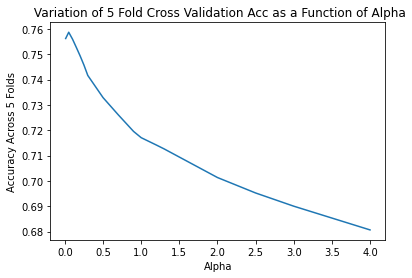

In [15]:
# plot the results as 
data = {'alpha': alpha, '5 fold scores':scores}
df = pd.DataFrame(data)
print("Best Alpha Value:", df.loc[df['5 fold scores'].idxmax()])
plt.plot(alpha, df['5 fold scores'].values)
plt.ylabel('Accuracy Across 5 Folds')
plt.xlabel('Alpha')
plt.title(" Variation of 5 Fold Cross Validation Acc as a Function of Alpha")
df

We see that a smoothing constant of 0.05 is the best

## Final Naive Bayes Model:

In [17]:
Nb = MultinomialNB(alpha=0.05)
start = time.time()
train_pred = Nb.fit(X_train,Y_train).predict(X_train)
test_pred = Nb.fit(X_train,Y_train).predict(X_test)
end = time.time()
print("Training Accuracy using best alpha:", evaluate_acc(train_pred, Y_train))
print("Test Accuracy using best alpha:", evaluate_acc(test_pred, Y_test))
print("Time for training (fitting and predicting) :", end - start, "seconds")    

Training Accuracy using best alpha: 0.9402510164398091
Test Accuracy using best alpha: 0.6919808815719597
Time for training (fitting and predicting) : 18.580891847610474 seconds


# Logistic Regression:

Try a first pass fitting of thhe logistic regression 


In [ ]:
from sklearn.linear_model import LogisticRegression
# fit a logistic regression model and c
start = time.time()
clf = LogisticRegression(random_state=0, multi_class= "multinomial", n_jobs=-1, max_iter=500).fit(X_train, Y_train)
p = clf.predict(X_test)
end = time.time()
print("training accuracy: ", clf.score(X_train, Y_train))
print("testing accuracy: ",evaluate_acc(p, Y_test))
print("Time for training (fitting and predicting on Test Set) :", end - start, "seconds")  

training accuracy:  0.9061339932826586
testing accuracy:  0.6826872012745618
Time for training (fitting and predicting on Test Set) : 222.38328886032104


## Create the folds for the hyper parameter grid search method:

In [ ]:
# create a list to keep the indices of the train and test tuples:
folds = []
# list comprehension to save the tuples
folds = [(tr, val) for (tr, val) in (cross_validation_split(np.array(X_train).shape[0], n_folds=5))]

## Do grid search for best hyper-paramerters:

In [ ]:
# define models and parameters (use n_job = -1 to parallelize)
model = LogisticRegression(max_iter=550, n_jobs=-1)
# create lists od hyperparameters and then make a dictionary
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2', 'l1']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
# do grid search using folds generated by the method written before for CV
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=folds, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, Y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Best: 0.745800 using {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.739346 (0.008231) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.739434 (0.008097) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.740760 (0.007832) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'lbfgs'}
0.696552 (0.011218) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'liblinear'}
0.742971 (0.007305) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.742971 (0.007305) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.745800 (0.008600) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


## Build Model using Best Parameters:

In [ ]:
# define models and parameters (use n_job = -1 to parallelize)
model = LogisticRegression(max_iter=550, solver='liblinear', C = 10, penalty='l2', class_weight='balanced')
print(" Model accuracy with CV :", kfoldCV(X_train, Y_train, 5, model)[1])
print(" Test accuracy on test set :", evaluate_acc(model.predict(X_test), Y_test))


 Model accuracy with CV : 0.7453580901856764
 Test accuracy on test set : 0.6729952203929899


# Testing for different training set sizes:

In [18]:
# Ploting the accuracy vs. training dataset size
n=X_train.shape[0]
a = [0.2, 0.4, 0.6, 0.8, 1]
accuracy_nb_test = []
accuracy_lr_test = []
accuracy_nb_train = []
accuracy_lr_train = []
# loop over fractions
for i in a:
    np.random.seed(500)
    # naive bayes
    clf1 = MultinomialNB(alpha=0.05).fit(X_train[:int(i*n)], Y_train[:int(i*n)])
    accuracy_nb_train.append(evaluate_acc(Y_train,clf1.predict(X_train)))
    accuracy_nb_test.append (evaluate_acc(Y_test,clf1.predict(X_test)))
    # logistic regression
    clf2 = LogisticRegression(max_iter=550, solver='liblinear', C = 10, penalty='l2', class_weight='balanced').fit(X_train[:int(i*n)], Y_train[:int(i*n)])
    accuracy_lr_train.append(evaluate_acc(Y_train,clf2.predict(X_train)))
    accuracy_lr_test.append (evaluate_acc(Y_test,clf2.predict(X_test)))


<Figure size 432x288 with 0 Axes>

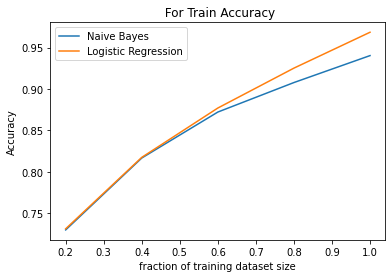

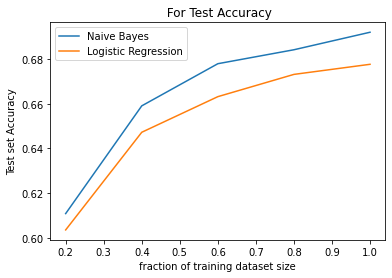

<Figure size 432x288 with 0 Axes>

In [19]:
# plot the training results
plt.plot(a,accuracy_nb_train, label ="Naive Bayes")
plt.plot(a,accuracy_lr_train, label ="Logistic Regression")
plt.xlabel('fraction of training dataset size')
plt.ylabel('Accuracy')
plt.title(" For Train Accuracy")
plt.legend()
plt.figure()
# plot test results
plt.plot(a,accuracy_nb_test, label ="Naive Bayes")
plt.plot(a,accuracy_lr_test, label ="Logistic Regression")
plt.xlabel('fraction of training dataset size')
plt.ylabel('Test set Accuracy')
plt.title(" For Test Accuracy")

plt.legend()
plt.figure()

# Training Using SGDC Classifier:
SVMs are some of the best NLP tools out there, especially the ones with linear kernels. Hence, I thought I would try it here:

In [16]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
text_clf = Pipeline([
       ('tfidf', TfidfVectorizer(stop_words='english', min_df=3)),
       ('clf', SGDClassifier(loss='hinge', penalty='l2',
       alpha=1e-3, random_state=42,
        max_iter=5, tol=None)), ])
start = time.time()
train_predicted = text_clf.fit(train_df.data, Y_train).predict(train_df.data)
test_predicted = text_clf.fit(train_df.data, Y_train).predict(test_df.data)
end = time.time()
print(" Training Accuracy:", evaluate_acc(train_predicted, Y_train))
print(" Testing Accuracy:", evaluate_acc(test_predicted, Y_test))
print(" Time when using SVM:", end - start)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, test_predicted)

from sklearn import metrics
print("Metrics per class:")
print(metrics.classification_report(Y_test, test_predicted, target_names=newsgroups_test.target_names))

 Training Accuracy: 0.8933180130811385
 Testing Accuracy: 0.6789697291556027
 Time when using SVM: 6.250964403152466
Metrics per class:
                          precision    recall  f1-score   support

             alt.atheism       0.60      0.39      0.47       319
           comp.graphics       0.66      0.66      0.66       389
 comp.os.ms-windows.misc       0.64      0.61      0.62       394
comp.sys.ibm.pc.hardware       0.65      0.63      0.64       392
   comp.sys.mac.hardware       0.72      0.69      0.70       385
          comp.windows.x       0.77      0.72      0.75       395
            misc.forsale       0.71      0.78      0.74       390
               rec.autos       0.76      0.69      0.72       396
         rec.motorcycles       0.50      0.77      0.60       398
      rec.sport.baseball       0.82      0.78      0.80       397
        rec.sport.hockey       0.79      0.92      0.85       399
               sci.crypt       0.74      0.74      0.74       396
     

# Testing Using a Binary Decision Tree:
We chose to build a decision tree classifier because it showed its potential in the previous miniassignment. We here compare it against the other 3 classifiers

In [10]:
# We calculate the performance of DecisionTreeClassifier model on the test dataset
from sklearn.tree import DecisionTreeClassifier
start = time.time()
clf = DecisionTreeClassifier().fit(X_train, Y_train)
predicted = clf.predict(X_test)
end = time.time()
print('Train accuracy:' , evaluate_acc(Y_train,clf.predict(X_train)))
print('Test accuracy:' , evaluate_acc(Y_test,predicted))
print("Time when using Tree Decision:", end - start)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, predicted)

from sklearn import metrics
print(metrics.classification_report(Y_test, predicted, target_names=newsgroups_test.target_names))

Train accuracy: 0.9728654764009192
Test accuracy: 0.43574083908656397
 Time when using Tree Decision: 366.8050694465637
                          precision    recall  f1-score   support

             alt.atheism       0.29      0.27      0.28       319
           comp.graphics       0.37      0.40      0.39       389
 comp.os.ms-windows.misc       0.45      0.43      0.44       394
comp.sys.ibm.pc.hardware       0.38      0.35      0.36       392
   comp.sys.mac.hardware       0.44      0.43      0.43       385
          comp.windows.x       0.51      0.44      0.47       395
            misc.forsale       0.57      0.57      0.57       390
               rec.autos       0.26      0.50      0.34       396
         rec.motorcycles       0.53      0.53      0.53       398
      rec.sport.baseball       0.63      0.52      0.57       397
        rec.sport.hockey       0.63      0.62      0.62       399
               sci.crypt       0.59      0.48      0.53       396
         sci.electron